In [1]:
from pyspark.sql.types import *

ratings_df_schema = StructType(
    [StructField('asin', StringType()),
    StructField('helpful', ArrayType(IntegerType())),
    StructField('overall', FloatType()),
    StructField('reviewText', StringType()),
    StructField('reviewTime', DateType()),
    StructField('reviewerID', StringType()),
    StructField('summary', StringType())])

# StructField('unixReviewTime', LongType())
# ['asin', 'description', 'title', 'categories']
metadata_df_schema = StructType(
    [StructField('asin', StringType()),
    StructField('description', StringType()),
    StructField('title', StringType()),
    StructField('categories', ArrayType(StringType()))])


In [2]:

#import metadata files

import gzip
from pyspark.sql import Row
from collections import OrderedDict
from datetime import datetime

def parse_metadata(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def create_metadata_df(path):
    metadata = []
    for entry in parse_metadata(path):
        metadata.append(entry)

  #find all keys
    all_keys = []
    for i in range(len(metadata)):
        for key in metadata[i].keys():
            if key not in all_keys:
                all_keys.append(key)
    print(all_keys)
  #['asin', 'categories', 'price', 'related'] in instant videos
  #['asin', 'imUrl', 'description', 'categories', 'title', 'related', 'price', 'salesRank', 'brand'] in electronics
  
  #check number of entries that contains each key
    key_count_dict = {}
    for key in all_keys:
        key_count_dict[key] = 0
    for i in range(len(metadata)):
        for key in all_keys:
            if key in metadata[i].keys():
                key_count_dict[key] += 1
    print(key_count_dict)  
#  {'asin': 498196, 'description': 459470, 'title': 491194, 'price': 389693, 'imUrl': 498021, 'related': 366959, 'salesRank': 128706, 'brand': 142532, 'categories': 498196} for electronics
    discard_missing_info_col = False
    cols_to_keep = ['asin', 'description', 'title', 'categories']
    filtered_metadata = []
    for i in range(len(metadata)):
        keep_col = True
        if discard_missing_info_col:
      #only retain items that contain info for all columns
            cols = [x for x in cols_to_keep if x in metadata[i].keys()]
            if len(cols) != len(cols_to_keep):
                keep_col = False
        if keep_col:
            temp_dict = {}
            for col in cols_to_keep: 
                if col not in metadata[i].keys():
                    temp_dict[col] = None
                elif col == 'categories':#given as array of array so only keeep the inner array
                    temp_dict[col] = metadata[i]['categories'][0]
                else:
                    temp_dict[col] = metadata[i][col]
            filtered_metadata.append(temp_dict)

    return sqlContext.createDataFrame(filtered_metadata, schema = metadata_df_schema)#schema=metadata_df_schema
  

# books_df = create_review_df('/dbfs/tmp/Metadata/Books.json.gz')
#instant_video_meta_df = create_metadata_df('/dbfs/tmp/Metadata/Instant_Video.json.gz')
# movies_df = create_review_df('/dbfs/tmp/Metadata/Movies_and_TV.json.gz')
# cds_df = create_review_df('/dbfs/tmp/Metadata/CDs_and_Vinyl.json.gz')
# instruments_df = create_review_df('/dbfs/tmp/Metadata/Musical_Instruments.json.gz')
# instant_video_df = create_review_df('/dbfs/tmp/Metadata/Instant_Videos.json.gz'



In [3]:
baby_meta_df = create_metadata_df('spark_notebooks/meta_Baby.json.gz')
baby_meta_df.cache()

['asin', 'categories', 'description', 'title', 'price', 'imUrl', 'brand', 'related', 'salesRank']
{'asin': 71317, 'categories': 71317, 'description': 65642, 'title': 71241, 'price': 57741, 'imUrl': 71243, 'brand': 27858, 'related': 58721, 'salesRank': 36}


DataFrame[asin: string, description: string, title: string, categories: array<string>]

In [4]:
baby_meta_df.count()
baby_meta_df.show(20)

+----------+--------------------+--------------------+----------+
|      asin|         description|               title|categories|
+----------+--------------------+--------------------+----------+
|0188399313|Wee-Go Glass baby...|Lifefactory 4oz B...|    [Baby]|
|0188399518|The Planet Wise F...|Planetwise Flanne...|    [Baby]|
|0188399399|The Planet Wise W...|Planetwise Wipe P...|    [Baby]|
|0316967297|Hand crafted set ...|Annas Dream Full ...|    [Baby]|
|0615447279|Thumbuddy To Love...|Stop Pacifier Suc...|    [Baby]|
|0670062049|A baby can be put...|5 Pink Gumdrops +...|    [Baby]|
|0705391752|Overview

Include...|A Tale of Baby's ...|    [Baby]|
|097293751X|Easily keep track...|Baby Tracker&reg;...|    [Baby]|
|0974671517|What should we ca...|Wee Gallery Twins...|    [Baby]|
|0980027519|These adorable, h...|Nature's Lullabie...|    [Baby]|
|0980027500|This calendar pro...|Nature's Lullabie...|    [Baby]|
|0980027586|This extra sticke...|Nature's Lullabie...|    [Baby]|
|098002759

In [5]:
#print # of distinct categories among all products
print(baby_meta_df.select('categories').distinct().count())

1


In [6]:
#import stopwords
stopwords_path = 'spark_notebooks/stopwords_eng.txt'
stopwords_rdd = sc.textFile(stopwords_path)
stopwords = stopwords_rdd.collect()
print(len(stopwords))
print(stopwords)

119
['a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also', 'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'but', 'by', 'can', 'cannot', 'could', 'dear', 'did', 'do', 'does', 'either', 'else', 'ever', 'every', 'for', 'from', 'get', 'got', 'had', 'has', 'have', 'he', 'her', 'hers', 'him', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'least', 'let', 'like', 'likely', 'may', 'me', 'might', 'most', 'must', 'my', 'neither', 'no', 'nor', 'not', 'of', 'off', 'often', 'on', 'only', 'or', 'other', 'our', 'own', 'rather', 'said', 'say', 'says', 'she', 'should', 'since', 'so', 'some', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'tis', 'to', 'too', 'twas', 'us', 'wants', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'would', 'yet', 'you', 'your']


In [7]:
#parse each column by itself instead
# feature hashing
#convert each row of metadata_df to list of tuple format 
from pyspark.sql.functions import udf, array, split
import re

def parse_row(col):
    if col == None:
        return [(0, 'EmptyString')]
    elif isinstance(col, str):
        words = re.split(r'\W+'col)
    elif type(col) is list:
        words = col
   
  #assign featureID to its index in all_words (e.g. des_words_ID = 0, title_words_ID = 1, etc.)
    tuple_list = []
    for word in words:
        lower_case_word = word.lower()
        if lower_case_word not in stopwords:
            tuple_list.append((0, lower_case_word))
    return tuple_list

  
parse_row_udf = udf(parse_row, ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))
tuple_baby_meta_df = baby_meta_df.select(baby_meta_df.asin, \
                                                       parse_row_udf(baby_meta_df.description).alias('description_features'), \
                                                       parse_row_udf(baby_meta_df.title).alias('title_features'), \
                                                       parse_row_udf(baby_meta_df.categories).alias('category_features'))
                                                                                                                    
if baby_meta_df.is_cached:
    baby_meta_df.unpersist()
if not tuple_baby_meta_df.is_cached:
    tuple_baby_meta_df.cache()


In [8]:
tuple_baby_meta_df.show(3)

+----------+--------------------+--------------------+-----------------+
|      asin|description_features|      title_features|category_features|
+----------+--------------------+--------------------+-----------------+
|0188399313|[[0,wee-go], [0,g...|[[0,lifefactory],...|       [[0,baby]]|
|0188399518|[[0,planet], [0,w...|[[0,planetwise], ...|       [[0,baby]]|
|0188399399|[[0,planet], [0,w...|[[0,planetwise], ...|       [[0,baby]]|
+----------+--------------------+--------------------+-----------------+
only showing top 3 rows



In [9]:
#check for null elements for each feature
print(tuple_baby_meta_df.where(tuple_baby_meta_df.description_features.isNull()).count())
print(tuple_baby_meta_df.where(tuple_baby_meta_df.title_features.isNull()).count())
print(tuple_baby_meta_df.where(tuple_baby_meta_df.category_features.isNull()).count())


0
0
0


In [10]:
def reduce(func, seq, initial):
    fix = initial
    for item in seq:
        fix = func(fix,item)
    return fix

In [11]:
from collections import defaultdict
import hashlib

def hash_function(raw_feats, num_buckets, print_mapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use print_mapping=True for debug purposes and to better understand how the hashing works.

    Args:
        raw_feats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        num_buckets (int): Number of buckets to use as features.
        print_mapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = { category + ':' + str(ind):
                int(int(hashlib.md5((category + ':' + str(ind)).encode('utf-8')).hexdigest(), 16) % num_buckets)
                for ind, category in raw_feats}
    if(print_mapping): print(mapping)

    def map_update(l, r):
        l[r] += 1.0
        return l

    sparse_features = reduce(map_update, mapping.values(), defaultdict(float))
    return dict(sparse_features)

In [13]:
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np


num_hash_buckets_description = 2 ** 5
num_hash_buckets_title = 2 ** 5
num_hash_buckets_category = 2 ** 0

# UDF that returns a vector of hashed features given an Array of tuples

def tuples_to_hash_features_desc(col):
  return Vectors.sparse(num_hash_buckets_description, hash_function(col, num_hash_buckets_description))
tuples_to_hash_features_desc_udf = udf(tuples_to_hash_features_desc, VectorUDT())

def tuples_to_hash_features_title(col):
  return Vectors.sparse(num_hash_buckets_title, hash_function(col, num_hash_buckets_title))
tuples_to_hash_features_title_udf = udf(tuples_to_hash_features_title, VectorUDT())

def tuples_to_hash_features_category(col):
  return Vectors.sparse(num_hash_buckets_category, hash_function(col, num_hash_buckets_category))
tuples_to_hash_features_category_udf = udf(tuples_to_hash_features_category, VectorUDT())


def add_hashed_features(df):
    """Return a DataFrame with labels and hashed features.

    Note:
        Make sure to cache the DataFrame that you are returning.

    Args:
        df (DataFrame with 'tuples' column): A DataFrame containing the tuples to be hashed.

    Returns:
        DataFrame: A DataFrame with a 'label' column and a 'features' column that contains a
            SparseVector of hashed features.
    """
    return (df.select(df.asin, \
                      tuples_to_hash_features_desc_udf(df.description_features).alias('description_hash_features'), \
                      tuples_to_hash_features_title_udf(df.title_features).alias('title_hash_features'), \
                      tuples_to_hash_features_category_udf(df.category_features).alias('category_hash_features')))

hash_baby_meta_df = add_hashed_features(tuple_baby_meta_df)

tuple_baby_meta_df.unpersist()
hash_baby_meta_df.cache().show(3)

+----------+-------------------------+--------------------+----------------------+
|      asin|description_hash_features| title_hash_features|category_hash_features|
+----------+-------------------------+--------------------+----------------------+
|0188399313|     (16,[0,1,2,3,4,5,...|(32,[11,12,13,15,...|       (32,[16],[1.0])|
|0188399518|     (16,[0,2,4,5,7,8,...|(32,[0,5,18],[1.0...|       (32,[16],[1.0])|
|0188399399|     (16,[0,1,2,4,5,6,...|(32,[0,21,30],[1....|       (32,[16],[1.0])|
+----------+-------------------------+--------------------+----------------------+
only showing top 3 rows



In [14]:
print(hash_baby_meta_df.where(hash_baby_meta_df.description_hash_features.isNull()).count())
print(hash_baby_meta_df.where(hash_baby_meta_df.title_hash_features.isNull()).count())
print(hash_baby_meta_df.where(hash_baby_meta_df.category_hash_features.isNull()).count())

0
0
0


In [15]:
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector


# combine_hash_features_udf = udf(lambda x1:x1, VectorUDT())
def combine_hash_features(col1, col2, col3):
#   if isinstance(col1,SparseVector) and isinstance(col2,SparseVector) and isinstance(col3,SparseVector):
  combined_array = np.concatenate((col1.toArray(),col2.toArray(), col3.toArray()))
  sparse_vec = {i:combined_array[i] for i in np.nonzero(combined_array)[0]}
  return Vectors.sparse(len(combined_array), sparse_vec)

combine_hash_features_udf = udf(combine_hash_features, VectorUDT())

hash_combined_baby_meta_df = hash_baby_meta_df.select(hash_baby_meta_df.asin, \
                                                                    combine_hash_features_udf(hash_baby_meta_df.description_hash_features, \
                                                                                              hash_baby_meta_df.title_hash_features, \
                                                                                              hash_baby_meta_df.category_hash_features).alias('features'))
hash_baby_meta_df.unpersist()
hash_combined_baby_meta_df.cache().show(3)


+----------+--------------------+
|      asin|            features|
+----------+--------------------+
|0188399313|(80,[0,1,2,3,4,5,...|
|0188399518|(80,[0,2,4,5,7,8,...|
|0188399399|(80,[0,1,2,4,5,6,...|
+----------+--------------------+
only showing top 3 rows



In [19]:
kmeans.explainParams()

'featuresCol: features column name. (default: features, current: features)\ninitMode: The initialization algorithm. This can be either "random" to choose random points as initial cluster centers, or "k-means||" to use a parallel variant of k-means++ (default: k-means||)\ninitSteps: The number of steps for k-means|| initialization mode. Must be > 0. (default: 2)\nk: The number of clusters to create. Must be > 1. (default: 2, current: 50)\nmaxIter: max number of iterations (>= 0). (default: 20)\npredictionCol: prediction column name. (default: prediction)\nseed: random seed. (default: 7969353092125344463, current: 1)\ntol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.0001)'

In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

num_clusters_list = [50,100,250, 500, 1000, 2000, 4000]
scores = []
models = []
for num_clusters in num_clusters_list:
    kmeans = KMeans(k=num_clusters, seed=1, featuresCol="features")
    model = kmeans.fit(hash_combined_baby_meta_df)
    models.append(model)
    score = model.computeCost(hash_combined_baby_meta_df)
    scores.append((num_clusters, score))
print(scores)

[(50, 2773210.5687812394), (100, 2552214.574113235), (250, 2254243.96515986), (500, 2023194.7844391232), (1000, 1782562.064981485), (2000, 1539711.151744904), (4000, 1276393.3798315022)]


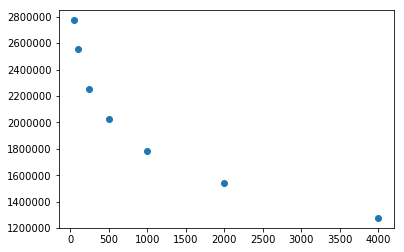

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

xs = [pair[0] for pair in scores]
ys = [pair[1] for pair in scores]
plt.scatter(xs,ys)
plt.show()

In [22]:
model.transform(hash_combined_baby_meta_df).show(20)

+----------+--------------------+----------+
|      asin|            features|prediction|
+----------+--------------------+----------+
|0188399313|(80,[0,1,2,3,4,5,...|         1|
|0188399518|(80,[0,2,4,5,7,8,...|         7|
|0188399399|(80,[0,1,2,4,5,6,...|        21|
|0316967297|(80,[0,2,3,4,5,6,...|        49|
|0615447279|(80,[0,1,2,3,4,5,...|        11|
|0670062049|(80,[0,1,2,3,4,5,...|        21|
|0705391752|(80,[0,1,2,3,4,5,...|        17|
|097293751X|(80,[0,1,2,3,4,5,...|        47|
|0974671517|(80,[1,2,3,4,5,6,...|        13|
|0980027519|(80,[0,1,3,7,8,11...|         7|
|0980027500|(80,[0,1,2,3,4,5,...|        42|
|0980027586|(80,[0,1,2,3,4,5,...|        14|
|0980027594|(80,[1,2,3,4,5,6,...|        14|
|0981257224|(80,[0,1,2,3,5,6,...|         0|
|0983676534|(80,[0,1,2,3,5,6,...|        29|
|0985072830|(80,[0,1,2,3,4,5,...|        24|
|1059879875|(80,[0,1,2,3,4,5,...|         2|
|1059875748|(80,[0,1,2,3,4,5,...|         2|
|141279000X|(80,[2,20,24,25,2...|        37|
|143210952

In [16]:
best_model = model[0]
transformed = best_model.transform(hash_combined_electronics_meta_df)
for k in range(best_model.summary.k)
  print transformed.filter(transformed.prediction == k).count()

rows = transformed.collect()

In [17]:
rows[:5]